# Includes:

In [1]:
%reload_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sn
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from data_paths import get_file_paths_ordered
from tf_lite_conversion import convert_to_tf_lite, eval_tf_lite_model
from scipy.io import wavfile
from IPython.display import Audio
from pre_process import choose_tot_slice_len, get_data_tensors, compute_mfccs
from models import get_model

In [16]:
NB_SPEAKERS = 5
dataset_percentage = 1 # 0.85
segmentLength=1024
print("Number of speakers : ", NB_SPEAKERS)

CSV_DIR = 'csv/'
MODEL_NAME =  str(NB_SPEAKERS) + '_qkeras'
TFLITE_MODEL_NAME = 'tflite_'+ MODEL_NAME[:-3]
C_MODEL_NAME = MODEL_NAME[:-3]

MODEL_DIR = 'Models/' + MODEL_NAME + '/'
# Create model directory
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

FIG_DIR = MODEL_DIR + 'Figures/'
if not os.path.exists(FIG_DIR):
    os.makedirs(FIG_DIR)

print("Model folder : ", MODEL_DIR)
print("Model names : ", MODEL_NAME,TFLITE_MODEL_NAME, C_MODEL_NAME)

Number of speakers :  5
Model folder :  Models/5_qkeras/
Model names :  5_qkeras tflite_5_qke 5_qke


# Read data:

In [3]:
paths_train, paths_test, y_train_l, y_test_l, all_paths_l  = get_file_paths_ordered(num_speaker = NB_SPEAKERS, 
                                                                                    test_ratio = 0.2,
                                                                                    balanced_dataset = True)

Total number of speakers in the original dataset: 20
Number of speakers that will be used for training:5 => 25.0%
Original number of files:  3306
Training number of files : 2260 => 68.36055656382335%


In [4]:
slice_len, durations = choose_tot_slice_len(paths=all_paths_l)

segmentLength = 1024

f_s, x_train, y_train, x_test, y_test = get_data_tensors(paths_train=paths_train, paths_test=paths_test, 
                                                         y_train_l=y_train_l, y_test_l=y_test_l,
                                                         tot_slice_len=slice_len,
                                                         used_train_sz_rat=dataset_percentage, 
                                                         used_test_sz_rat=1.,
                                                         segmentLength=segmentLength)

print("Train - test size : ", x_train.shape, x_test.shape)

Visualization of the samples ...


100%|██████████| 566/566 [00:00<00:00, 1481.65it/s]


Train - test size :  (2260, 171, 1024) (566, 171, 1024)


Play a random sample:

In [5]:
i=1
fs_i, audio_data_i = wavfile.read(paths_train[i])
display(Audio(audio_data_i, rate=fs_i))

# Pre-Processing:

In [6]:
f_low=80.
f_up=7600.
num_mel_bins=80
num_mfcc=13
segmentLength=1024

x_train_mfcc = compute_mfccs(x_train, frame_length=segmentLength, sample_rate=f_s, 
                             lower_edge_hertz=f_low, upper_edge_hertz=f_up,
                             num_mel_bins=num_mel_bins, num_mfcc=num_mfcc)
x_test_mfcc  = compute_mfccs(x_test, frame_length=segmentLength, sample_rate=f_s, 
                             lower_edge_hertz=f_low, upper_edge_hertz=f_up,
                             num_mel_bins=num_mel_bins, num_mfcc=num_mfcc)

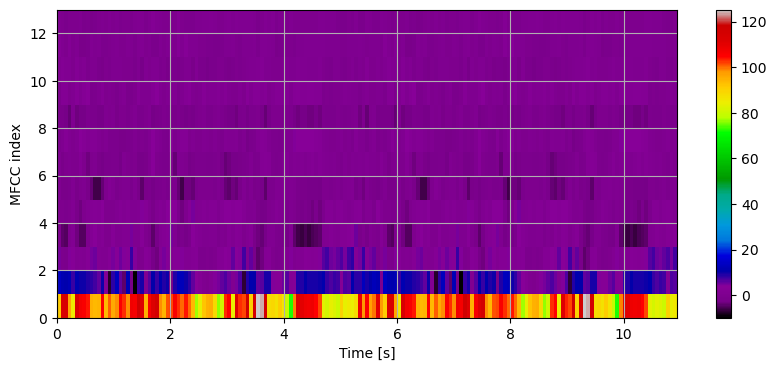

In [7]:
plt.figure(figsize=(10, 4))
extent = [0, x_train_mfcc[i].shape[0]*segmentLength/fs_i, 0, num_mfcc]
plt.imshow(tf.transpose(x_train_mfcc[i], [1, 0, 2]), interpolation="nearest", origin="lower", 
           aspect="auto", extent=extent, cmap='nipy_spectral')
plt.colorbar()
plt.xlabel("Time [s]")
plt.ylabel("MFCC index")
plt.grid()
#plt.savefig(path_figures + 'mfcc_example.png')
plt.show()

# Define the Model:

In [8]:
train_set = x_train_mfcc
test_set = x_test_mfcc
print(train_set.shape)

(2260, 171, 13, 1)


# Keras Model

In [10]:
from models import get_model
model_idx = 1
input_shape = train_set.shape
model = get_model(input_shape=input_shape, nb_classes=NB_SPEAKERS, model_idx=model_idx)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (2260, 171, 13, 1)       3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (2260, 171, 13, 16)       160       
                                                                 
 batch_normalization (BatchN  (2260, 171, 13, 16)      64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (2260, 171, 13, 16)       0         
                                                                 
 conv2d_1 (Conv2D)           (2260, 86, 7, 32)         4640      
                                                                 
 batch_normalization_1 (Batc  (2260, 86, 7, 32)        1

In [12]:
batchSize = 32 #8 # nb of togetherly processed segments(of 1024 samples each) 
epochs = 150 #40 # nb of back propagations
loss_fct = 'sparse_categorical_crossentropy'

model.compile(
    loss=loss_fct, 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint(MODEL_DIR + MODEL_NAME + '_keras.h5', save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=15, min_lr=1.0e-5,verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, verbose=1),       
]

history_keras = model.fit(x=train_set, 
                          y=y_train, 
                          batch_size=batchSize, 
                          epochs=epochs, 
                          validation_split=0.2,
                          callbacks = callbacks)

Epoch 1/150
57/57 [==============================] - 5s 60ms/step - loss: 0.7242 - accuracy: 0.7467 - val_loss: 1.9945 - val_accuracy: 0.2323 - lr: 0.0010
Epoch 2/150
57/57 [==============================] - 3s 55ms/step - loss: 0.2841 - accuracy: 0.9154 - val_loss: 0.9782 - val_accuracy: 0.6040 - lr: 0.0010
Epoch 3/150
57/57 [==============================] - 3s 56ms/step - loss: 0.1634 - accuracy: 0.9519 - val_loss: 2.6338 - val_accuracy: 0.1814 - lr: 0.0010
Epoch 4/150
57/57 [==============================] - 3s 57ms/step - loss: 0.1445 - accuracy: 0.9563 - val_loss: 3.9656 - val_accuracy: 0.3119 - lr: 0.0010
Epoch 5/150
57/57 [==============================] - 3s 56ms/step - loss: 0.1306 - accuracy: 0.9602 - val_loss: 2.4745 - val_accuracy: 0.4358 - lr: 0.0010
Epoch 6/150
57/57 [==============================] - 3s 54ms/step - loss: 0.1200 - accuracy: 0.9624 - val_loss: 3.5126 - val_accuracy: 0.3916 - lr: 0.0010
Epoch 7/150
57/57 [==============================] - 3s 54ms/step - lo

In [13]:
y_pred = model.predict(test_set)

test_loss, test_acc = model.evaluate(test_set,  y_test, verbose=2)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

18/18 [==============================] - 1s 17ms/step
18/18 - 0s - loss: 0.0812 - accuracy: 0.9823 - 290ms/epoch - 16ms/step
Test accuracy: 0.982332170009613
Test loss: 0.08122677356004715


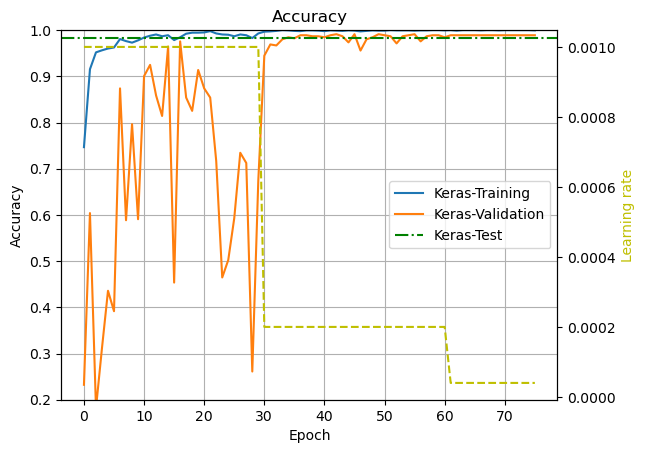

In [17]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# plt.figure()
ax1.plot(history_keras.history['accuracy'], label='Keras-Training')
ax1.plot(history_keras.history['val_accuracy'], label='Keras-Validation')
ax1.axhline(y=test_acc, xmin=0, xmax=epochs, linestyle='-.', color='g', label='Keras-Test')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([1/NB_SPEAKERS, 1])
ax2.plot(history_keras.history['lr'], color='y', linestyle='--')
ax2.set_ylabel('Learning rate', color='y')
ax1.legend(loc='right')
plt.grid()
ax1.grid()
ax2.grid()
plt.title("Accuracy")
plt.savefig(FIG_DIR + 'keras_acc_epochs.png')
plt.show()

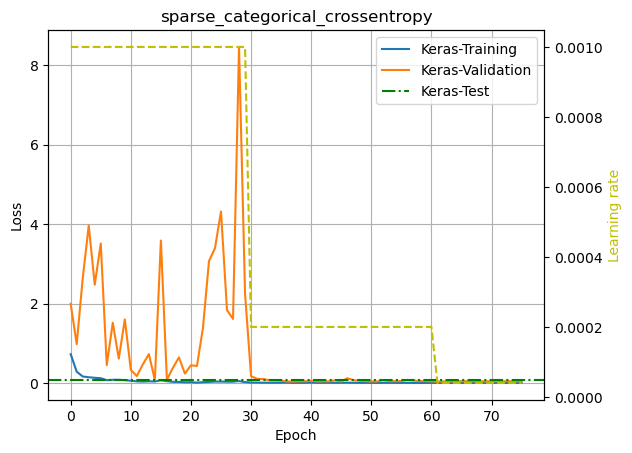

In [18]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# plt.figure()
ax1.plot(history_keras.history['loss'], label='Keras-Training')
ax1.plot(history_keras.history['val_loss'], label='Keras-Validation')
ax1.axhline(y=test_loss, xmin=0, xmax=epochs, linestyle='-.', color='g', label='Keras-Test')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax2.plot(history_keras.history['lr'], color='y', linestyle='--')
ax2.set_ylabel('Learning rate', color='y')
ax2.grid()
ax1.legend(loc='upper right')
plt.grid()
plt.title(loss_fct)
plt.savefig(FIG_DIR + 'keras_loss_epochs.png')
plt.show()

In [19]:
# Show the model size for Keras model 
model_save_path = MODEL_DIR + MODEL_NAME + '_keras.h5'
h5_in_kb = os.path.getsize(model_save_path) / 1024
print("Keras model file : ", model_save_path)
print("HDF5 Keras Model size: %d KB" % h5_in_kb)

Keras model file :  Models/5_qkeras/5_qkeras_keras.h5
HDF5 Keras Model size: 1293 KB


# QKeras Model

150 epoch quantized bits no bias qact in the end :  0.58

In [38]:
from qkeras import *
from tensorflow.keras import layers, regularizers

In [44]:
def qmodel(input_shape, nb_classes):

    model = tf.keras.models.Sequential()
    #Normalize data
    model.add(layers.Normalization())

    model.add(QConv2D(filters=3, kernel_size=(3,3), padding="same", input_shape=input_shape,
                      kernel_quantizer="quantized_bits(8, 7, alpha=1)", 
                      use_bias = False, # less parameters ? 
                      name="conv2d_1"))
    model.add(layers.BatchNormalization())
    model.add(QActivation("quantized_relu(2)", name="act_1"))

    model.add(QConv2D(filters=16, kernel_size=(3,3), strides=(2,2), padding='same',
                      kernel_quantizer="binary(alpha=1)", 
                      use_bias = False,     
                      name="conv2d_2"))    
    model.add(layers.BatchNormalization())
    model.add(QActivation("quantized_relu(2)", name="act_2"))

    model.add(layers.MaxPool2D((2,2)))

    model.add(QConv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding='same',
                      kernel_quantizer="quantized_bits(8, 7, alpha=1)", 
                      use_bias = False, # less parameters ? 
                      name="conv2d_3"))
    model.add(layers.BatchNormalization())
    model.add(QActivation("quantized_relu(2)", name="act_3"))

    model.add(layers.MaxPool2D((2,2)))

    model.add(QConv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same',
                      kernel_quantizer="quantized_bits(8, 7, alpha=1)", 
                      use_bias = False, # less parameters ? 
                      name="conv2d_4"))
    model.add(layers.BatchNormalization())
    model.add(QActivation("quantized_relu(2)", name="act_4"))

    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Flatten())

    model.add(QDense(8, kernel_regularizer=(regularizers.l1(0)),
                     kernel_quantizer="binary(alpha=1)",
                     bias_quantizer="binary(alpha=1)",
                     name="dense_1"))
    model.add(QActivation("quantized_relu(2)", name="act_5"))

    model.add(QDense(nb_classes,
                     kernel_quantizer="binary(alpha=1)",
                     bias_quantizer="binary(alpha=1)",
                     name="dense_2"))  # Nb classes to recognize
    model.add(layers.Activation("softmax", name="softmax"))  # Softmax to get probas of each class
    

    return model

In [45]:
qmodel = qmodel(train_set.shape, NB_SPEAKERS)
qmodel.build(input_shape=train_set.shape)
qmodel.summary()

c:\Users\emili\anaconda3\envs\ml\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (2260, 171, 13, 1)       3         
 ion)                                                            
                                                                 
 conv2d_1 (QConv2D)          (2260, 171, 13, 3)        27        
                                                                 
 batch_normalization_16 (Bat  (2260, 171, 13, 3)       12        
 chNormalization)                                                
                                                                 
 act_1 (QActivation)         (2260, 171, 13, 3)        0         
                                                                 
 conv2d_2 (QConv2D)          (2260, 86, 7, 16)         432       
                                                                 
 batch_normalization_17 (Bat  (2260, 86, 7, 16)       

In [41]:
batchSize = 32 #8 # nb of togetherly processed segments(of 1024 samples each) 
epochs = 150 #40 # nb of back propagations
loss_fct = 'sparse_categorical_crossentropy'

Compile the model and Fit the Data:\
@TODO use weights giving the highest accuracy on the validation dataset

In [46]:
qmodel.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint(MODEL_DIR + MODEL_NAME + '_qkeras_best.h5',save_best_only=True,verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=15, min_lr=1.0e-5,verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1),       
]

history = qmodel.fit(
    x = train_set, 
    y = y_train, 
    validation_split=0.2,
    callbacks = callbacks, 
    batch_size = batchSize, 
    epochs = 300
)

Epoch 1/300
56/57 [============================>.] - ETA: 0s - loss: 1.8913 - accuracy: 0.2249
Epoch 1: val_loss improved from inf to 1.94514, saving model to Models/5_qkeras\5_qkeras_qkeras_best.h5
57/57 [==============================] - 16s 83ms/step - loss: 1.8941 - accuracy: 0.2235 - val_loss: 1.9451 - val_accuracy: 0.1991 - lr: 0.0010
Epoch 2/300
56/57 [============================>.] - ETA: 0s - loss: 1.8307 - accuracy: 0.2411
Epoch 2: val_loss improved from 1.94514 to 1.93006, saving model to Models/5_qkeras\5_qkeras_qkeras_best.h5
57/57 [==============================] - 3s 57ms/step - loss: 1.8323 - accuracy: 0.2395 - val_loss: 1.9301 - val_accuracy: 0.1991 - lr: 0.0010
Epoch 3/300
56/57 [============================>.] - ETA: 0s - loss: 1.8264 - accuracy: 0.2444
Epoch 3: val_loss did not improve from 1.93006
57/57 [==============================] - 3s 54ms/step - loss: 1.8281 - accuracy: 0.2428 - val_loss: 2.1445 - val_accuracy: 0.2522 - lr: 0.0010
Epoch 4/300
56/57 [=======

Evaluate the performance on the test set:

In [47]:
y_pred = qmodel.predict(test_set)

test_loss, test_acc = qmodel.evaluate(test_set,  y_test, verbose=1)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

18/18 [==============================] - 0s 9ms/step - loss: 0.6733 - accuracy: 0.7968
Test accuracy: 0.796819806098938
Test loss: 0.6733253002166748


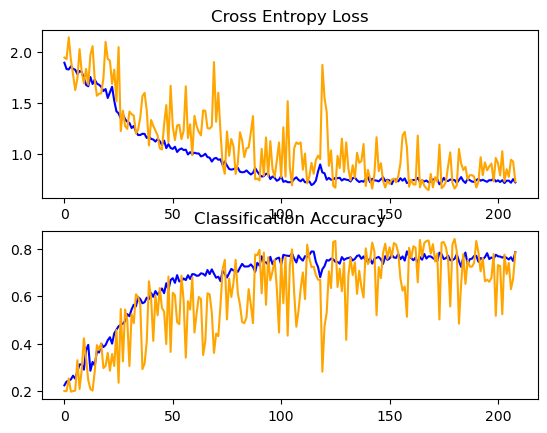

In [48]:
# learning curves
# plot diagnostic learning curves
import sys
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# plot loss
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')
pyplot.plot(history.history['val_accuracy'], color='orange', label='test')

In [73]:
print_qstats(qmodel)

Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.



Number of operations in model:
    conv2d_1                      : 60021 (smult_8_8)
    conv2d_2                      : 260064 (smux_1_2)
    conv2d_3                      : 202752 (smult_8_2)
    conv2d_4                      : 110592 (smult_8_2)
    dense_1                       : 512   (smux_1_2)
    dense_2                       : 40    (smux_1_2)

Number of operation types in model:
    smult_8_2                     : 313344
    smult_8_8                     : 60021
    smux_1_2                      : 260616

Weight profiling:
    conv2d_1_weights               : 27    (8-bit unit)
    conv2d_1_bias                  : 0     (32-bit unit)
    conv2d_2_weights               : 432   (1-bit unit)
    conv2d_2_bias                  : 0     (32-bit unit)
    conv2d_3_weights               : 4608  (8-bit unit)
    conv2d_3_bias                  : 0     (32-bit unit)
    conv2d_4_weights               : 18432 (8-bit unit)
    conv2d_4_bias                  : 0     (32-bit unit)
    dens

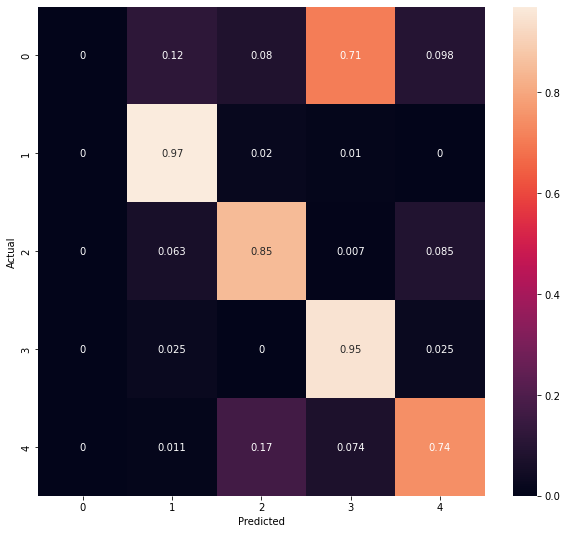

In [75]:
y_pred_hard = np.argmax(y_pred, axis=1)
fig = plt.figure(figsize=(10,9))
cm = confusion_matrix(y_test, y_pred_hard, normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [99]:
model_save_path = os.path.join(MODEL_DIR, MODEL_NAME + '.h5')
qmodel.save(model_save_path)

In [88]:
# Show the model size for QKeras model 
h5_in_kb = os.path.getsize(model_save_path) / 1024
print("QKeras Model file : ", model_save_path)
print("QKeras Model size without quantization: %d KB" % h5_in_kb)

QKeras Model file :  Models\5_qkeras\5_qkeras.h5
QKeras Model size without quantization: 387 KB


# QKeras Bias

In [34]:
def qmodel(input_shape, nb_classes):

    model = tf.keras.models.Sequential()
    #Normalize data
    model.add(layers.Normalization())

    model.add(QConv2D(filters=3, kernel_size=(3,3), padding="same", input_shape=input_shape,
                      kernel_quantizer="quantized_bits(8, 7, alpha=1)", 
                      use_bias = True, 
                      name="conv2d_1"))
    model.add(layers.BatchNormalization())
    model.add(QActivation("quantized_relu(2)", name="act_1"))

    model.add(QConv2D(filters=16, kernel_size=(3,3), strides=(2,2), padding='same',
                      kernel_quantizer="binary(alpha=1)", 
                      use_bias = True,     
                      name="conv2d_2"))    
    model.add(layers.BatchNormalization())
    model.add(QActivation("quantized_relu(2)", name="act_2"))

    model.add(layers.MaxPool2D((2,2)))

    model.add(QConv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding='same',
                      kernel_quantizer="quantized_bits(8, 7, alpha=1)", 
                      use_bias = True, 
                      name="conv2d_3"))
    model.add(layers.BatchNormalization())
    model.add(QActivation("quantized_relu(2)", name="act_3"))

    model.add(layers.MaxPool2D((2,2)))

    model.add(QConv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same',
                      kernel_quantizer="quantized_bits(8, 7, alpha=1)", 
                      use_bias = True, 
                      name="conv2d_4"))
    model.add(layers.BatchNormalization())
    model.add(QActivation("quantized_relu(2)", name="act_4"))

    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Flatten())

    model.add(QDense(8, kernel_regularizer=(regularizers.l1(0)),
                     kernel_quantizer="binary(alpha=1)",
                     bias_quantizer="binary(alpha=1)",
                     name="dense_1"))
    model.add(QActivation("quantized_relu(2)", name="act_5"))

    model.add(QDense(nb_classes,
                     kernel_quantizer="binary(alpha=1)",
                     bias_quantizer="binary(alpha=1)",
                     name="dense_2"))  # Nb classes to recognize
    model.add(QActivation("softmax", name="softmax"))  # Softmax to get probas of each class
    

    return model

In [35]:
qmodel = qmodel(train_set.shape, NB_SPEAKERS)
qmodel.build(input_shape=train_set.shape)
qmodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (2260, 171, 13, 1)       3         
 ion)                                                            
                                                                 
 conv2d_1 (QConv2D)          (2260, 171, 13, 3)        30        
                                                                 
 batch_normalization_8 (Batc  (2260, 171, 13, 3)       12        
 hNormalization)                                                 
                                                                 
 act_1 (QActivation)         (2260, 171, 13, 3)        0         
                                                                 
 conv2d_2 (QConv2D)          (2260, 86, 7, 16)         448       
                                                                 
 batch_normalization_9 (Batc  (2260, 86, 7, 16)       

Compile the model and Fit the Data:\
@TODO use weights giving the highest accuracy on the validation dataset

In [36]:
qmodel.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint(MODEL_DIR + MODEL_NAME + '_qkeras_best.h5',save_best_only=True,verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=15, min_lr=1.0e-5,verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1),       
]

history = qmodel.fit(
    x = train_set, 
    y = y_train, 
    validation_split=0.2,
    callbacks = callbacks, 
    batch_size = 32, 
    epochs = 300
)

Epoch 1/300
56/57 [============================>.] - ETA: 0s - loss: 1.8569 - accuracy: 0.2048
Epoch 1: val_loss improved from inf to 1.87773, saving model to Models/5_qkeras\5_qkeras_qkeras_best.h5
57/57 [==============================] - 7s 66ms/step - loss: 1.8541 - accuracy: 0.2052 - val_loss: 1.8777 - val_accuracy: 0.1704 - lr: 0.0010
Epoch 2/300
55/57 [===========================>..] - ETA: 0s - loss: 1.7365 - accuracy: 0.2131
Epoch 2: val_loss improved from 1.87773 to 1.78573, saving model to Models/5_qkeras\5_qkeras_qkeras_best.h5
57/57 [==============================] - 2s 37ms/step - loss: 1.7321 - accuracy: 0.2146 - val_loss: 1.7857 - val_accuracy: 0.1881 - lr: 0.0010
Epoch 3/300
57/57 [==============================] - ETA: 0s - loss: 1.6842 - accuracy: 0.2152
Epoch 3: val_loss improved from 1.78573 to 1.66640, saving model to Models/5_qkeras\5_qkeras_qkeras_best.h5
57/57 [==============================] - 2s 37ms/step - loss: 1.6842 - accuracy: 0.2152 - val_loss: 1.6664 - 

Evaluate the performance on the test set:

In [37]:
y_pred = qmodel.predict(test_set)

test_loss, test_acc = qmodel.evaluate(test_set,  y_test, verbose=1)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

18/18 [==============================] - 0s 17ms/step - loss: 1.0862 - accuracy: 0.3763
Test accuracy: 0.3763251006603241
Test loss: 1.0862040519714355


In [ ]:
y_pred = qmodel.predict(test_set)

test_loss, test_acc = qmodel.evaluate(test_set,  y_test, verbose=1)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

18/18 [==============================] - 0s 11ms/step - loss: 0.9253 - accuracy: 0.5795
Test accuracy: 0.5795053243637085
Test loss: 0.9252944588661194


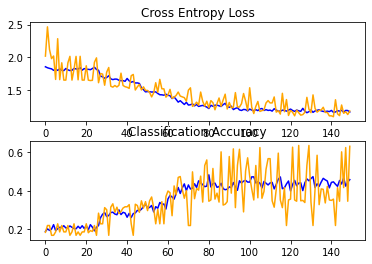

In [ ]:
# learning curves
# plot diagnostic learning curves
import sys
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# plot loss
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')
pyplot.plot(history.history['val_accuracy'], color='orange', label='test')

In [ ]:
print_qstats(qmodel)

Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.



Number of operations in model:
    conv2d_1                      : 60021 (smult_8_8)
    conv2d_2                      : 260064 (smux_1_2)
    conv2d_3                      : 202752 (smult_8_2)
    conv2d_4                      : 110592 (smult_8_2)
    dense_1                       : 512   (smux_1_2)
    dense_2                       : 40    (smux_1_2)

Number of operation types in model:
    smult_8_2                     : 313344
    smult_8_8                     : 60021
    smux_1_2                      : 260616

Weight profiling:
    conv2d_1_weights               : 27    (8-bit unit)
    conv2d_1_bias                  : 0     (32-bit unit)
    conv2d_2_weights               : 432   (1-bit unit)
    conv2d_2_bias                  : 0     (32-bit unit)
    conv2d_3_weights               : 4608  (8-bit unit)
    conv2d_3_bias                  : 0     (32-bit unit)
    conv2d_4_weights               : 18432 (8-bit unit)
    conv2d_4_bias                  : 0     (32-bit unit)
    dens

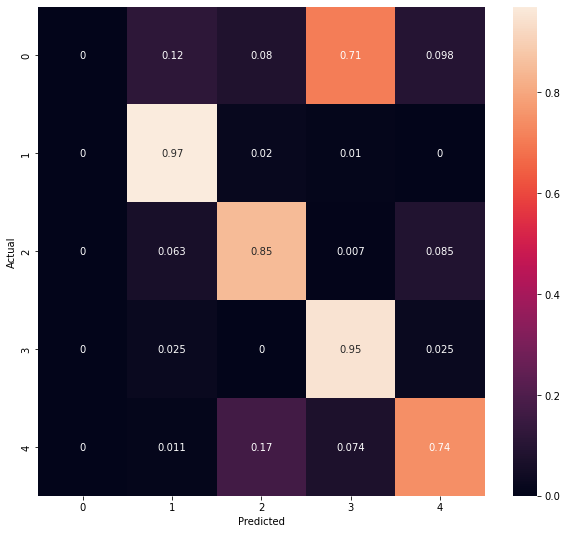

In [ ]:
y_pred_hard = np.argmax(y_pred, axis=1)
fig = plt.figure(figsize=(10,9))
cm = confusion_matrix(y_test, y_pred_hard, normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
model_save_path = os.path.join(MODEL_DIR, MODEL_NAME + '.h5')
qmodel.save(model_save_path)

In [ ]:
# Show the model size for QKeras model 
h5_in_kb = os.path.getsize(model_save_path) / 1024
print("QKeras Model file : ", model_save_path)
print("QKeras Model size without quantization: %d KB" % h5_in_kb)

QKeras Model file :  Models\5_qkeras\5_qkeras.h5
QKeras Model size without quantization: 387 KB
